# Calculate HS in CMIP6 models
## Goal: Use Gregory regression to calculate ECS $\Delta T$ [Gregory et al 2004](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003GL018747) 

### Using the first member of abrupt-4xCO2 simulations available on the [CMIP analysis platform](https://www2.cisl.ucar.edu/resources/cmip-analysis-platform)

## Potentially useful utilities to get the pathnames 

### get areacella the cheaty way for most models (from manually downloaded files and, when that fails, brute force $d\phi *cos(\phi)$)

In [1]:
import sys
import os
import datetime

%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
def getendpath(pathtovar,var):
    # basedir/institution/model/experiment/variant/Amon/"+variable / gridlabel / version {latest/vDATE} 
    # we begin from here:  basedir/institution/model/experiment/variant/Amon/variable/ 
    # the next level is the gridlabel
    gridlabel=os.listdir(pathtovar)
    extrabit = False
    # the next level is the version. options are: 'latest' or 'vYYYYMMDD'; sometimes there's a red herring something called 'files' 
    possible_versions = os.listdir(pathtovar+"/"+gridlabel[0])
    versions = []
    # get rid of folders that don't have netcdf files
    for aversion in possible_versions:
        files = os.listdir(pathtovar+"/"+gridlabel[0]+"/"+aversion)
        #print(aversion)
        #print(files)
        ncfiles = [item for item in files if item.endswith('.nc')]
        if len(ncfiles)>0:
            versions.append(aversion)
    if len(versions)==0:
        # try again with the variable name appended. models other than CESM have this.
        for aversion in possible_versions:
            files = os.listdir(pathtovar+"/"+gridlabel[0]+"/"+aversion+"/"+var)
            #print(aversion)
            #print(files)
            ncfiles = [item for item in files if item.endswith('.nc')]
            if len(ncfiles)>0:
                versions.append(aversion)
                extrabit = True
    #print(len(versions))
    if len(versions)==1:
        # if there's only one folder, this is easy
        theendpath = "/"+gridlabel[0]+"/"+versions[0]+"/"
    elif len(versions)==0:
        # nothing made the cut, return empty string
        theendpath = []
    else:
        # there are multiple possibilities
        # if one of them is "latest", we'll take it
        hasLatest = any(elem == 'latest' for elem in versions)
        if hasLatest:
            theendpath = "/"+gridlabel[0]+"/"+'latest'+"/"
        else:
            # if there's no latest, there should be folders of the form 'vYYYYMMDD'. 
            datevs = [item for item in versions if item.startswith('v')]
            if len(datevs)==1:
                # there was only one properly formatted folder - get it
                theendpath = "/"+gridlabel[0]+"/"+datevs[0]+"/"
            elif len(datevs)>1:
                # there are multiple dated versions. 
                # sort and take the most recent one
                datelist = [datetime.datetime.strptime(item[1:],'%Y%m%d') for item in versions]
                datelist.sort(reverse=True)
                latestversion='v'+datelist[0].strftime('%Y%m%d')
                theendpath = "/"+gridlabel[0]+"/"+latestversion+"/"
            else:
                # something went wrong; give up
                theendpath = []
    return theendpath,extrabit

In [3]:
def getvariants(pathtoexp,var):
    variants = []
    endpaths = [] 
    extrabit = []
    directories = os.listdir(pathtoexp)
    for variant in sorted(os.listdir(pathtoexp)):
        try: 
            # check that there is actually a path for this particular variable in this experiment
            os.listdir(pathtoexp+variant+"/Amon/"+var)
            #print(variant)
            # we will now call a function that gets the end path. this is not trivial; it includes the grid label and finding the latest version. 
            thispath = pathtoexp+variant+"/Amon/"+var
            #print(thispath)
            thisendpath,extrabit = getendpath(thispath,var)
            # if this all worked, then add the variant / ensemble member, and its path info, to the list of existing ones
            if len(thisendpath)>0:
                endpaths.append(thisendpath)
                variants.append(variant)
        except:
            # in case there is not actually any data for this model + variant / ensemble member
            #print(pathtoexp+" "+variant+" is missing")
            pass
    #print(variants)
    return variants,endpaths,extrabit

In [4]:
def getOneModelExperimentVar(model,experiment,var):
    basedir = '/glade/collections/cmip/CMIP6/CMIP/'
    thisModelExpVar = []
    institutions = []
    for institution in os.listdir(basedir):
        #print(institution)
        models = os.listdir(basedir+institution)
        hasmodel = any(elem == model for elem in models)
        if hasmodel:
            institutions.append(institution)        
    if len(institutions)==1:
        institution = institutions[0]
        exps = os.listdir(basedir+institution+"/"+model)
        hasexp = any(elem == experiment for elem in exps)
        if (hasexp) : 
            # get ensemble members with data and also their end paths
            variants,endpaths,extrabit = getvariants(basedir+institution+"/"+model+"/"+experiment+"/",var)
            if len(variants)>0:
                thisModelExpVar = ModelExpVar(model,experiment,var,basedir+institution+"/"+model,variants,endpaths,extrabit)
    elif len(institutions)>1:
        print("Multiple institutions, same model")
        print(institutions)
    return thisModelExpVar

In [5]:
def getModelsForExperimentVar(experiment,var):
    basedir = '/glade/collections/cmip/CMIP6/CMIP/'
    evd_ofmodels = {}
    for institution in os.listdir(basedir):
        #print(institution)
        for model in os.listdir(basedir+institution):
            #print(institution+"/"+model)
            exps = os.listdir(basedir+institution+"/"+model)
            #print(exps)
            hasexp = any(elem == experiment for elem in exps)
            if (hasexp) : 
                # get ensemble members with data and also their end paths
                variants,endpaths,extrabit = getvariants(basedir+institution+"/"+model+"/"+experiment+"/",var)
                if len(variants)>0:
                    evd_ofmodels[model] = ModelExpVar(model,experiment,var,basedir+institution+"/"+model,variants,endpaths,extrabit)

    return evd_ofmodels

In [6]:
class ModelArea:
  def __init__(self,model,file,areacella):
    self.model = model
    self.variable = "areacella"
    self.file = file
    self.areacella = areacella
    
def getModelAreacella(model):
    basedir = "/glade/collections/cmip/CMIP6/CMIP/"
    experiment="piControl"
    var="areacella"
    thisModelExpVar = []
    institutions = []
    thisModelArea = []
    # this first method will work for CESM2. Maybe nothing else. 
    for institution in os.listdir(basedir):
        #print(institution)
        models = os.listdir(basedir+institution)
        hasmodel = any(elem == model for elem in models)
        if hasmodel:
            institutions.append(institution)        
    if len(institutions)==1:
        institution = institutions[0]
        exps = os.listdir(basedir+institution+"/"+model)
        hasexp = any(elem == experiment for elem in exps)
        if (hasexp) : 
            # get ensemble members with data and also their end paths
            variants,endpaths,extraVarFolder = getFXvariants(basedir+institution+"/"+model+"/"+experiment+"/",var)
            if len(variants)>0:
                thepath = basedir+institution+"/"+model+"/"+experiment+"/"+variants[0]+"/fx/"+var+endpaths[0]
                if extraVarFolder:
                    thepath = thepath+var+"/"
                files = os.listdir(thepath)
                thisModelArea = ModelArea(model,thepath+files[0],[])
    elif len(institutions)>1:
        print("Multiple institutions, same model")
        print(institutions)
    # If that didn't work, then we try something else. Next step is the folder with areacella files I downloaded. 
    if thisModelArea==[]:
        areacelladir="/glade/work/apgrass/pythonhackathon/areacella/"
        files = os.listdir(areacelladir)
        thefile = [item for item in files if model in item]
        #print(thefile)
        if len(thefile)>0:
            thisModelArea = ModelArea(model,areacelladir + thefile[0],[])
    if thisModelArea!=[]:
        ds = xr.open_mfdataset(thisModelArea.file)
        areacella = ds.get(thisModelArea.variable)
        thisModelArea.areacella = areacella
    else:
        # Finally, if that still didn't work, we just do lat/lon weighting. Leave it empty
        thismodeltas = getOneModelExperimentVar(model,experiment,"tas")
        ds = xr.open_mfdataset(thismodeltas.variants[list(thismodeltas.variants)[0]][0])
        tas1time = ds.tas.sel(time=(ds.time[-1]))
        l1=np.array(tas1time.lat)
        l2=np.copy(l1)
        l2[1:]=l1[0:-1]
        l2[0]=-90
        l3=np.copy(l1)
        l3[0:-1]=l1[1:]
        l3[-1]=90
        lw = np.cos(l1*np.pi/180)*(l3-l2)
        areacella = xr.DataArray(np.transpose(np.tile(lw,[len(tas1time.lon),1])),coords = tas1time.coords, dims = tas1time.dims)
        thisModelArea = ModelArea(model,[],areacella)
    return thisModelArea

In [7]:
def getFXvariants(pathtoexp,var):
    variants = []
    endpaths = [] 
    extrabit = []
    for variant in os.listdir(pathtoexp):
        try: 
            # check that there is actually a path for this particular variable in this experiment
            os.listdir(pathtoexp+variant+"/fx/"+var)
            #print(variant)
            # we will now call a function that gets the end path. this is not trivial; it includes the grid label and finding the latest version. 
            thispath = pathtoexp+variant+"/fx/"+var
            #print(thispath)
            thisendpath,extrabit = getendpath(thispath,var)
            # if this all worked, then add the variant / ensemble member, and its path info, to the list of existing ones
            if len(thisendpath)>0:
                endpaths.append(thisendpath)
                variants.append(variant)
        except:
            # in case there is not actually any data for this model + variant / ensemble member
            #print(pathtoexp+" "+variant+" is missing")
            pass
    #print(variants)
    return variants,endpaths,extrabit

In [8]:
def globalannualmean(aModelExpVar,areacella,mem):
    weight= areacella / areacella.sum(dim=('lon','lat'))
    weight.sum(dim=('lon','lat'))
    try:
        ds = xr.open_mfdataset(aModelExpVar.variants[mem][:])
        it = ds.get(aModelExpVar.variable)
        itGm=(np.tile(weight,[len(ds.time),1,1])*it).sum(dim=('lat','lon'))
        if len(ds.time)>=1800:
            # this is to get the first 150 years from abrupt-4xCO2
            starttimes = ds.time[0:150*12]
            its=itGm.sel(time=slice(starttimes[0],starttimes[-1]))
            itGm_annual = its.resample(time='A',label='left',loffset='6M').mean(dim='time')
        else:
            itGm_annual = itGm.resample(time='A',label='left',loffset='6M').mean(dim='time')
    except:
    # IPSL-CM6A-LR abrupt-4xCO2 has a member that goes for 900 yrs and breaks this. if it fails, just get the first member
        print("globalannualmean: "+aModelExpVar.model+" "+mem+" trying just first file")
        ds = xr.open_mfdataset(aModelExpVar.variants[mem][0])
        it = ds.get(aModelExpVar.variable)
        itGm=(np.tile(weight,[len(ds.time),1,1])*it).sum(dim=('lat','lon'))
        starttimes = ds.time[0:150*12]
        its=itGm.sel(time=slice(starttimes[0],starttimes[-1]))
        itGm_annual = its.resample(time='A',label='left',loffset='6M').mean(dim='time')
    return itGm_annual


In [9]:
def climglobalmean(aModelExpVar,areacella):
    weight= areacella / areacella.sum(dim=('lon','lat'))
    weight.sum(dim=('lon','lat'))
    # average across all piControl members
    c = []
    for mem in list(aModelExpVar.variants):
        ds = xr.open_mfdataset(aModelExpVar.variants[mem][:])
        endtimes = ds.time[-(12*30):]
        #print(aModelExpVar.variable)
        it = ds.get(aModelExpVar.variable)
        it_c=it.sel(time=slice(endtimes[0],endtimes[-1])).mean(dim=('time'))
        itGm=(it_c*weight).sum(dim=('lat','lon'))
        c.append(itGm.values)
        c.append(itGm.values)
    itGm_c = np.average(c)
    return itGm_c


In [10]:
def getChangeTimeseries(model,var,mem,areacella):
    v4x = getOneModelExperimentVar(model,"abrupt-4xCO2",var)
    vpi = getOneModelExperimentVar(model,"piControl",var)
    vGAm = globalannualmean(v4x,areacella,mem)
    vpi_c = climglobalmean(vpi,areacella)
    change = vGAm-vpi_c
    return change

In [11]:
class ModelExpVar:
  def __init__(self, model, experiment, variable,startpath,variants,endpaths,extraVarFolder):
    self.model = model
    self.experiment = experiment
    self.variable = variable
    # The rest are derived
    ## basedir/institution/model/experiment/variant/Amon/"+variable / gridlabel / version {latest/vDATE} / SOMETIMES extrafolder
    paths = []
    files = []
    for i in range(len(variants)):
        #print(variants[i])
        thepath = startpath+"/"+experiment+"/"+variants[i]+"/Amon/"+variable+endpaths[i]
        if extraVarFolder:
            thepath = thepath+variable+"/"
        ensfiles = os.listdir(thepath)
        thisensfiles = []
        for file in ensfiles:
            if file.endswith(".nc"):
                # deals with duplicate files in GISS-E2-1-G
                if (model+"_"+experiment in file):  
                    thisensfiles.append(thepath+file)
        files.append(sorted(thisensfiles))
    self.variants = dict(zip(variants, files))


In [12]:
def calcECStas(model,mem):
    thisModelArea = getModelAreacella(model)
    dts = getChangeTimeseries(model,"tas",mem,thisModelArea.areacella)
    drsdt = getChangeTimeseries(model,"rsdt",mem,thisModelArea.areacella)
    drsut = getChangeTimeseries(model,"rsut",mem,thisModelArea.areacella)
    drlut = getChangeTimeseries(model,"rlut",mem,thisModelArea.areacella)
    dN = drsdt - drsut - drlut
    slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
    ECS = -intercept / slope
    return ECS,intercept



In [13]:
model = "CESM2"
cesm4x = getOneModelExperimentVar(model,"abrupt-4xCO2","ts")
imem = list(cesm4x.variants)[0]
thisModelArea = getModelAreacella(model)
dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
drsdt = getChangeTimeseries(model,"rsdt",imem,thisModelArea.areacella)
drsut = getChangeTimeseries(model,"rsut",imem,thisModelArea.areacella)
drlut = getChangeTimeseries(model,"rlut",imem,thisModelArea.areacella)
dN = drsdt - drsut - drlut
slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
cesmECS = -intercept / slope

In [14]:
print(cesmECS)
print(cesmECS/2)

10.236966252031683
5.118483126015842


In [15]:
list(cesm4x.variants)[0]

'r1i1p1f1'

In [16]:
dpr = getChangeTimeseries(model,"pr",imem,thisModelArea.areacella)


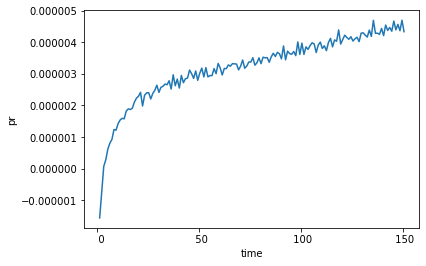

In [17]:
dpr.plot()

In [18]:
def calcHS(model,mem):
    thisModelArea = getModelAreacella(model)
    dt = getChangeTimeseries(model,"tas",mem,thisModelArea.areacella)
    L=2.5e6
    dp = getChangeTimeseries(model,"pr",mem,thisModelArea.areacella)*L
    slope, intercept, r_value, p_value, std_err = stats.linregress(dt,dp)
    thedp = float(dp[-10:].mean() ) 
    thedt = float(dt[-10:].mean() )
    apparent = float(thedp / thedt)
    # perhaps also write out dp and dt
    vpi = getOneModelExperimentVar(model,"piControl","pr")
    vpi_c = climglobalmean(vpi,thisModelArea.areacella)
    theoutputs = [apparent,slope,intercept,thedp,thedt,vpi_c*L]
    return theoutputs


In [19]:
thisModelArea = getModelAreacella(model)
dt = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
L=2.5e6
dp = getChangeTimeseries(model,"pr",imem,thisModelArea.areacella)*L
slope, intercept, r_value, p_value, std_err = stats.linregress(dt,dp)
thedp = float(dp[-10:].mean() ) 
thedt = float(dt[-10:].mean() )
apparent = float(thedp / thedt)
# perhaps also write out dp and dt
vpi = getOneModelExperimentVar(model,"piControl","pr")
vpi_c = climglobalmean(vpi,thisModelArea.areacella)
theoutputs = [apparent,slope,intercept,thedp,thedt,vpi_c*L]

In [20]:
theoutputs = [apparent,slope,intercept,thedp,thedt,vpi_c*L]
theoutputs

[1.5337990335931737,
 2.1986232493630316,
 -4.729590652250534,
 11.185892105102539,
 7.292932033538818,
 85.29667866241653]

In [21]:
theoutputs = calcHS("CESM2",imem)
# theoutputs = [appHS,eta,adjustment,dp,dt,p]


In [22]:
# theoutputs = [appHS,eta,adjustment,dp,dt,p]
theoutputs

[1.513952151697018,
 2.1903692688423586,
 -4.881282258166646,
 11.185892105102539,
 7.388537406921387,
 85.29667866241653]

## Next: Make it work for CMIP6

In [23]:
def keepModelsWithAllData(modeldict1,modeldict2):
    missingmodel = set(list(modeldict1)).symmetric_difference(list(modeldict2))
    for model in missingmodel:
        #print(model)
        try: 
            modeldict1.pop(model)
        except:
            pass
        try: 
            modeldict2.pop(model)
        except:
            pass
    return modeldict1,modeldict2

In [24]:
var="tas"
ts4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
len(ts4x_models)


15

In [25]:
var="ts"
ts4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
len(ts4x_models)


15

In [26]:
var="pr"
ts4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
len(ts4x_models)


15

In [27]:
var="tas"
ts4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
tsPi_models = getModelsForExperimentVar("piControl",var)
ts4x_models,tsPi_models = keepModelsWithAllData(ts4x_models,tsPi_models)
variables = ["pr"]
for var in variables:
    #print(var)
    v4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
    vPi_models = getModelsForExperimentVar("piControl",var)
    v4x_models,vPi_models = keepModelsWithAllData(v4x_models,vPi_models)
    ts4x_models,v4x_models = keepModelsWithAllData(ts4x_models,v4x_models)
list(ts4x_models)

['CNRM-CM6-1',
 'CNRM-ESM2-1',
 'BCC-ESM1',
 'BCC-CSM2-MR',
 'CESM2-WACCM',
 'CESM2',
 'SAM0-UNICON',
 'UKESM1-0-LL',
 'GISS-E2-1-H',
 'GISS-E2-1-G',
 'CanESM5',
 'MRI-ESM2-0',
 'MIROC6',
 'IPSL-CM6A-LR']

In [28]:
len(ts4x_models)

14

In [29]:
# get rid of variants with less than 150 years of data for abrupt 4xCO2
for model in list(ts4x_models):
    thisModelArea = getModelAreacella(model)
    for mem in list(ts4x_models[model].variants):
        print(mem)
        vGAm = globalannualmean(ts4x_models[model],thisModelArea.areacella,mem) 
        print(len(vGAm))
        if len(vGAm)<150:
            ts4x_models[model].variants.pop(mem)
    

r1i1p1f2
150
r2i1p1f2
10
r3i1p1f2
10
r4i1p1f2
10
r5i1p1f2
10
r6i1p1f2
10
r1i1p1f2
150
r2i1p1f2
150
r3i1p1f2
150
r1i1p1f1
150
r1i1p1f1
150
r1i1p1f1
150
r1i1p1f1
150
r1i1p1f1
150
r1i1p1f2
150
r1i1p1f1
150
r1i1p1f1
150
r1i1p1f1
150
r1i1p2f1
150
r10i1p1f1
150
r11i1p1f1
6
r12i1p1f1
6
r13i1p1f1
150
r1i1p1f1
150
r2i1p1f1
6
r3i1p1f1
6
r4i1p1f1
150
r5i1p1f1
6
r6i1p1f1
6
r7i1p1f1
150
r8i1p1f1
6
r9i1p1f1
6
r1i1p1f1
150
r10i1p1f1
6
r11i1p1f1
6
r12i1p1f1
6
r1i1p1f1
globalannualmean: IPSL-CM6A-LR r1i1p1f1 trying just first file
150
r2i1p1f1
6
r3i1p1f1
6
r4i1p1f1
6
r5i1p1f1
6
r6i1p1f1
6
r7i1p1f1
6
r8i1p1f1
6
r9i1p1f1
6


In [30]:
# Make sure our models still have variants
for model in list(ts4x_models):
    print(len(ts4x_models[model].variants))
    if len(ts4x_models[model].variants)==0:
        ts4x_models.pop(model)

1
3
1
1
1
1
1
1
1
1
2
5
1
1


In [31]:
len(ts4x_models)

14

In [32]:
HS_models = ts4x_models

In [33]:
theoutputs
allHS = []
allHS.append(theoutputs)
allHS.append(theoutputs)
np.average(allHS)
print(theoutputs)

[1.513952151697018, 2.1903692688423586, -4.881282258166646, 11.185892105102539, 7.388537406921387, 85.29667866241653]


In [34]:
a=np.zeros([len(HS_models[model].variants),len(theoutputs)])
a=np.zeros([2,len(theoutputs)])
print(a)
a[0,:]=theoutputs
np.mean(a,axis=0)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


array([ 0.75697608,  1.09518463, -2.44064113,  5.59294605,  3.6942687 ,
       42.64833933])

In [35]:
HS={}
for model in list(HS_models):
    print(model)
    allHS = []
    count = 0 
    for mem in list(HS_models[model].variants):
        print(mem)
        theoutputs = calcHS(model,mem)
        a[0,:]=theoutputs
        count = count+1
        print(theoutputs)
    HS[model] = np.mean(a,axis=0)
    
    
# theoutputs = [appHS,eta,adjustment,dp,dt,p]


CNRM-CM6-1
r1i1p1f2
[1.2999155120290815, 1.9608275655950131, -4.293305710713929, 8.56759262084961, 6.590884208679199, 84.14285730395932]
CNRM-ESM2-1
r1i1p1f2
[1.2916347532764625, 1.7434465219505952, -2.9792592518021443, 8.12652587890625, 6.291659355163574, 84.59091986878775]
r2i1p1f2
[1.292358750554484, 1.767116565014403, -3.07900221712425, 8.046420097351074, 6.2261505126953125, 84.59091986878775]
r3i1p1f2
[1.2997206545959743, 1.8076277750901732, -3.3171469065499952, 8.088563919067383, 6.223309516906738, 84.59091986878775]
BCC-ESM1
r1i1p1f1
[1.3497544866161844, 2.1055894888384863, -3.881178384477324, 6.898736520671569, 5.111104715026068, 80.74238512888999]
BCC-CSM2-MR
r1i1p1f1
[1.3964884560068416, 2.2402269530850747, -4.012059749030406, 6.698874943111579, 4.796942584306447, 85.0957950998486]
CESM2-WACCM
r1i1p1f1
[1.4451366683857658, 2.1867778966721727, -4.775104610479627, 9.620315551757812, 6.6570281982421875, 84.61190191155765]
CESM2
r1i1p1f1
[1.513952151697018, 2.1903692688423586, -4

In [36]:
HS

{'CNRM-CM6-1': array([ 0.64995776,  0.98041378, -2.14665286,  4.28379631,  3.2954421 ,
        42.07142865]),
 'CNRM-ESM2-1': array([ 0.64986033,  0.90381389, -1.65857345,  4.04428196,  3.11165476,
        42.29545993]),
 'BCC-ESM1': array([ 0.67487724,  1.05279474, -1.94058919,  3.44936826,  2.55555236,
        40.37119256]),
 'BCC-CSM2-MR': array([ 0.69824423,  1.12011348, -2.00602987,  3.34943747,  2.39847129,
        42.54789755]),
 'CESM2-WACCM': array([ 0.72256833,  1.09338895, -2.38755231,  4.81015778,  3.3285141 ,
        42.30595096]),
 'CESM2': array([ 0.75697608,  1.09518463, -2.44064113,  5.59294605,  3.6942687 ,
        42.64833933]),
 'SAM0-UNICON': array([ 0.78291083,  1.34097423, -3.23178798,  4.62619352,  2.95448303,
        43.85117336]),
 'UKESM1-0-LL': array([ 0.86450493,  1.2372971 , -2.89628503,  6.67045199,  3.85796062,
        44.67870542]),
 'GISS-E2-1-H': array([ 0.55980558,  0.98668079, -2.12522487,  2.79770231,  2.49881601,
        43.10945315]),
 'GISS-E2-1

In [37]:
import csv



In [44]:
w = csv.writer(open("cmip6-dpdt.csv", "w"))

# theoutputs = [appHS,eta,adjustment,dp,dt,p]
w.writerow('[appHS,eta,adjustment,dp,dt,p]')
for key, val in HS.items():
    w.writerow([key, val])


In [39]:

ahs = {}
for key,val in HS.items():
    ahs[key]=val[0]/val[4]*100.
    


In [40]:
ahs

{'CNRM-CM6-1': 19.72293050327434,
 'CNRM-ESM2-1': 20.884718188369863,
 'BCC-ESM1': 26.40827300305665,
 'BCC-CSM2-MR': 29.11205275992998,
 'CESM2-WACCM': 21.708435436211,
 'CESM2': 20.490552707749544,
 'SAM0-UNICON': 26.499080246111422,
 'UKESM1-0-LL': 22.40834002310463,
 'GISS-E2-1-H': 22.40283319957371,
 'GISS-E2-1-G': 22.328173846199935,
 'CanESM5': 20.400861700602352,
 'MRI-ESM2-0': 32.62019560041279,
 'MIROC6': 30.444805245484417,
 'IPSL-CM6A-LR': 17.24661542370832}

In [41]:
orderedHS = sorted(ahs.items(), key=lambda x: x[1])
oHS = { pair[0]:pair[1] for pair in orderedHS }
print(oHS)    

{'IPSL-CM6A-LR': 17.24661542370832, 'CNRM-CM6-1': 19.72293050327434, 'CanESM5': 20.400861700602352, 'CESM2': 20.490552707749544, 'CNRM-ESM2-1': 20.884718188369863, 'CESM2-WACCM': 21.708435436211, 'GISS-E2-1-G': 22.328173846199935, 'GISS-E2-1-H': 22.40283319957371, 'UKESM1-0-LL': 22.40834002310463, 'BCC-ESM1': 26.40827300305665, 'SAM0-UNICON': 26.499080246111422, 'BCC-CSM2-MR': 29.11205275992998, 'MIROC6': 30.444805245484417, 'MRI-ESM2-0': 32.62019560041279}


Text(0.5, 1.0, 'Appartent HS for models on the CMIP analysis platform (25 Jul 2019)')

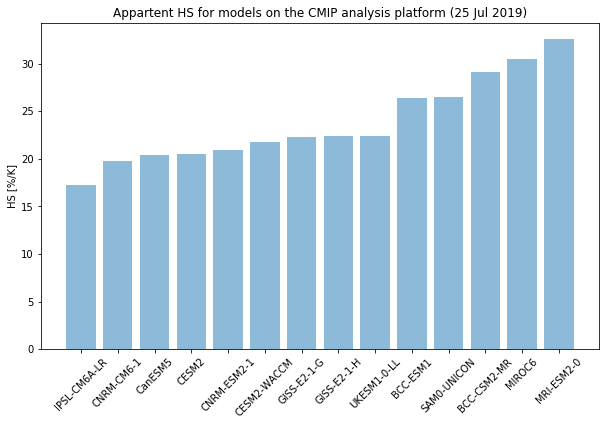

In [42]:
objects = oHS.keys()
y_pos = np.arange(len(objects))
performance = oHS.values()


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=45)
plt.ylabel('HS [%/K]')
plt.title('Appartent HS for models on the CMIP analysis platform ('+datetime.date.today().strftime('%d %b %Y')+')')

In [43]:
fig.savefig('cmip6-hs.pdf')